<a href="https://colab.research.google.com/github/MikeElias14/SYDE522/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset (s):
- This has game data: https://www.kaggle.com/nathanlauga/nba-games
- Here is a good one for player data: https://www.kaggle.com/justinas/nba-players-data

Reference Code:
- https://www.kaggle.com/jbthornt02/nba-game-prediction-model-v1/data


Following is PCA for choosing best n features.

Note: I manually uploaded the dataset, this means that it will disapear from the workspace whenever we reload the workspace. Once we find a dataset we will be using forever we should upload to drive and mount it perminantly.

I think we can import directly from kaggle:

--> Account Kaggle --> Expire API Token --> Create New Token (downloads a json file). Then:

! pip install -q kaggle
files.upload()

Make directory

!mkdir ~/.kaggle/
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Check it worked:
! kaggle datasets list

Now we can add the data in different ways:
! kaggle competitions download -c 'name of the competition'
or
! kaggle datasets download -d datasetfolder/dataset-name




In [0]:
# Pre-steps to add the dataset
!pip install -q kaggle
from google.colab import files

files.upload() #choose the json file

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

! kaggle datasets download -d pablote/nba-enhanced-stats/ # im gonna play around with this one today
# reference algorithm: https://www.kaggle.com/jbthornt02/nba-game-prediction-model-v1#NBA-Game-Prediction-Model-Verson-1

! mkdir train
! unzip nba-enhanced-stats.zip -d train



Saving kaggle.json to kaggle.json
ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)    1GB  2020-04-17 22:02:37          56360  
roche-data-science-coalition/uncover                           UNCOVER COVID-19 Challenge                          123MB  2020-04-08 22:04:30           5106  
praveengovi/coronahack-chest-xraydataset                       CoronaHack -Chest X-Ray-Dataset                       1GB  2020-03-20 01:26:40           1268  
katerpillar/meteonet                                           MeteoNet North-West France                           11GB  2020-04-16 08:35:45             98  
andrewmvd/co

In [0]:
# Summary of the model: use knn to classify the algorithm 
# then use different models to see what happens: SVM, Random Forest, and Gradient Boosting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np 
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.naive_bayes import GaussianNB
from sklearn.semi_supervised import LabelPropagation
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import graphviz
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')
import pickle


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# For 2016-2017 Train/Validate data:

df = pd.read_csv('train/2016-17_teamBoxScore.csv')
print(df.shape)

# Get rid of stuff
data = df.copy()  # First, copy the data and work with 'data'

# Pop the features we obviously will not need. We will assume that a team only plays one game per day, so we don't need the start time:
data.pop('teamConf')
data.pop('teamDiv')
data.pop('opptConf')
data.pop('opptDiv')
data.pop('offLNm1')
data.pop('offFNm1')
data.pop('offLNm2')
data.pop('offFNm2')
data.pop('offLNm3')
data.pop('offFNm3')
data.pop('gmTime')
data.pop('seasTyp') 
data.pop('poss') 
# data.pop('pace') 
data.pop('teamMin') 
data.pop('opptMin') 

features = data.columns

# Stat features are the one we will calc the moving avg of, and only for the home team. We will put the games together later.
stat_features = features[5:54]
oppt_stat_features = features[58:]

# Sort by team, reindex and break data into team data.
data.sort_values('teamAbbr', inplace=True)
data.reset_index(drop=True, inplace=True)

split_indexs = []
split_indexs.append(0)
orig_team_name = data['teamAbbr'][0]

for i in range(len(data)):
  team_name = data['teamAbbr'][i]
  if team_name != orig_team_name:
    split_indexs.append(i)
    orig_team_name = team_name

split_indexs.append(len(data))

list_team_data = [data.iloc[split_indexs[n]:split_indexs[n+1]] for n in range(len(split_indexs)-1)] # Yay python ;)

if len(list_team_data) == 30:
  print('Splitting into team data worked!')

###
# Now for each team, sort by date, reindex, and compute the stats up untill that date,
for i in range(len(list_team_data)):  # For each team
  team_data = list_team_data[i]

  team_data.sort_values('gmDate', inplace=True)
  team_data.reset_index(drop=True, inplace=True)

  #Set stats to start at 0
  stat_totals = {stat_features[n]: 0 for n in range(len(stat_features))}

  for j in range(len(team_data)):  # For each game
    old_stat_totals = stat_totals.copy()
    game = team_data.iloc[[j]]

    for feature in stat_features:
      stat_totals[feature] = stat_totals[feature] + game[feature][j]

      if j == 0:
        team_data.at[j, feature] = old_stat_totals[feature]  # Dumb edge case
      else:
        team_data.at[j, feature] = old_stat_totals[feature]/j
  
  print("Team for " + team_data['teamAbbr'][0] + " done.")


### 
# UPDATE:
# We now have each game, sorted by team and date, with the avg of the HOME team's stats up till before the game.
# We know the opponent for each game. We must now plug in the stats from the opponent for that game.
# After this step, we can cat all the data into one big df again, and continue with the new data.
###

# Now, replace the oppt data with the correct one. ONLY FOR HOME GAMES.

for i in range(len(list_team_data)): # For each team
  team_data = list_team_data[i]

  for j in range(len(team_data)): # For each game
    game = team_data.iloc[[j]]

    if game['teamLoc'][j] == 'Home':  # Only for home games
      oppt = game['opptAbbr'][j]
      date = game['gmDate'][j]

      for n in range(len(list_team_data)):  # Get oppt data
        if list_team_data[n]['teamAbbr'][0] == oppt:
          oppt_data = list_team_data[n]
          break

      oppt_game = oppt_data.loc[oppt_data['gmDate'] == date]

      # Fill oppt data into game data
      for m in range(len(stat_features)):
        team_data.at[j, oppt_stat_features[m]] = oppt_game.loc[oppt_game['gmDate'] == date][stat_features[m]]
      
  print("Oppt for " + team_data['teamAbbr'][0] + " done.")

# Now we can put all the list_team_data back together

list_team_data[0].drop(list_team_data[0].head(1).index, inplace=True)
new_data = list_team_data[0].copy()

for i in range(len(list_team_data)-1):
  list_team_data[i+1].drop(list_team_data[i+1].head(1).index, inplace=True)
  temp_data = new_data.copy()
  new_data = temp_data.append(list_team_data[i+1], ignore_index = True)

new_data = new_data[new_data['teamLoc'] == 'Home']  # Only get home games
new_data.reset_index(drop=True, inplace=True)

new_data.head()

(2460, 123)
Splitting into team data worked!
Team for ATL done.
Team for BKN done.
Team for BOS done.
Team for CHA done.
Team for CHI done.
Team for CLE done.
Team for DAL done.
Team for DEN done.
Team for DET done.
Team for GS done.
Team for HOU done.
Team for IND done.
Team for LAC done.
Team for LAL done.
Team for MEM done.
Team for MIA done.
Team for MIL done.
Team for MIN done.
Team for NO done.
Team for NY done.
Team for OKC done.
Team for ORL done.
Team for PHI done.
Team for PHO done.
Team for POR done.
Team for SA done.
Team for SAC done.
Team for TOR done.
Team for UTA done.
Team for WAS done.
Oppt for ATL done.
Oppt for BKN done.
Oppt for BOS done.
Oppt for CHA done.
Oppt for CHI done.
Oppt for CLE done.
Oppt for DAL done.
Oppt for DEN done.
Oppt for DET done.
Oppt for GS done.
Oppt for HOU done.
Oppt for IND done.
Oppt for LAC done.
Oppt for LAL done.
Oppt for MEM done.
Oppt for MIA done.
Oppt for MIL done.
Oppt for MIN done.
Oppt for NO done.
Oppt for NY done.
Oppt for OKC

,gmDate,teamAbbr,teamLoc,teamRslt,teamDayOff,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,teamFGM,teamFG%,team2PA,team2PM,team2P%,team3PA,team3PM,team3P%,teamFTA,teamFTM,teamFT%,teamORB,teamDRB,teamTRB,teamPTS1,teamPTS2,teamPTS3,teamPTS4,teamPTS5,teamPTS6,teamPTS7,teamPTS8,teamTREB%,teamASST%,teamTS%,teamEFG%,teamOREB%,teamDREB%,...,oppt2PM,oppt2P%,oppt3PA,oppt3PM,oppt3P%,opptFTA,opptFTM,opptFT%,opptORB,opptDRB,opptTRB,opptPTS1,opptPTS2,opptPTS3,opptPTS4,opptPTS5,opptPTS6,opptPTS7,opptPTS8,opptTREB%,opptASST%,opptTS%,opptEFG%,opptOREB%,opptDREB%,opptTO%,opptSTL%,opptBLK%,opptBLKR,opptPPS,opptFIC,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,pace
0,2016-10-31,ATL,Home,Win,2,109,29,16,12,7,16,86,43,0.497050,63,34,0.542650,23,8,0.355750,20,14,0.715000,10,39,49,29,26,22,31,0,0,0,0,55.586450,68.722950,0.570450,0.545850,23.983700,83.555550,...,30,0.511033,22,7,0.310633,29,23,0.777633,9,28,37,28,28,24,24,0,0,0,0,48.309167,64.885133,0.557967,0.500400,22.702133,74.548367,13.355233,6.455567,3.552600,5.388967,1.301333,70.708333,58.829100,111.756867,107.039533,4.717333,0.429067,17.801533,1.645167,41.872700,93.8695
1,2016-11-02,ATL,Home,Loss,2,108,27,15,11,6,17,84,39,0.470600,58,30,0.511433,25,9,0.359400,29,19,0.682333,12,35,47,26,27,23,30,0,0,0,0,54.943800,70.057733,0.557533,0.526333,27.553767,82.976433,...,29,0.513650,29,8,0.291825,23,18,0.812950,11,30,41,26,24,25,27,0,0,0,0,48.869725,47.202400,0.529325,0.483275,25.359700,73.241500,15.938025,9.549275,3.816550,6.449475,1.181175,64.000000,53.221850,102.168950,108.234650,-6.065700,0.400825,13.258475,0.976525,52.305675,101.2079
2,2016-11-05,ATL,Home,Win,1,106,27,16,11,4,19,84,38,0.455940,57,29,0.513160,26,8,0.324400,30,20,0.695800,11,34,45,27,24,26,28,0,0,0,0,52.560980,70.418780,0.546260,0.508360,25.854740,79.797120,...,26,0.541680,35,13,0.365280,26,18,0.712120,10,31,42,32,29,24,22,0,0,0,0,51.865720,61.179100,0.583220,0.550620,26.058580,76.138840,14.165600,7.806620,3.095700,6.236560,1.332300,80.625000,67.136400,114.605660,111.836280,2.769380,0.445900,17.878020,1.903100,51.817200,99.6632
3,2016-11-09,ATL,Home,Win,1,107,26,17,10,4,18,83,39,0.473614,57,30,0.530271,26,9,0.343043,28,19,0.681514,11,34,45,26,27,27,26,0,0,0,0,52.794200,67.170971,0.559714,0.527486,26.935557,78.011229,...,31,0.489400,21,7,0.352143,26,21,0.820814,14,35,49,27,29,24,26,0,0,0,0,56.282943,59.317586,0.552229,0.502100,33.085157,79.989300,13.131729,7.219443,5.395043,8.169029,1.251457,86.446429,72.005586,113.397714,106.611900,6.785814,0.455800,17.148700,1.758429,49.023843,103.3244
4,2016-11-12,ATL,Home,Win,3,108,26,18,10,5,18,83,40,0.477662,58,31,0.529462,25,9,0.356413,28,19,0.698175,11,34,46,27,27,27,25,0,0,0,0,53.948087,65.917462,0.565500,0.531575,28.082500,78.724938,...,26,0.473175,28,9,0.343537,19,13,0.705938,7,35,43,24,25,24,20,1,0,0,0,48.980137,59.237862,0.516325,0.486013,17.443125,79.984137,15.931988,7.192262,6.064988,10.865862,1.137200,66.734375,54.024912,96.149225,107.012713,-10.863488,0.383938,16.183450,1.242200,41.076513,100.2123


In [0]:
### For 2017-18 test Data: ###

df2 = pd.read_csv('train/2017-18_teamBoxScore.csv')

# Get rid of stuff

data2 = df2.copy()  # First, copy the data2 and work with 'data2'

# Pop the features we obviously will not need. We will assume that a team only plays one game per day, so we don't need the start time:
data2.pop('teamConf')
data2.pop('teamDiv')
data2.pop('opptConf')
data2.pop('opptDiv')
data2.pop('offLNm1')
data2.pop('offFNm1')
data2.pop('offLNm2')
data2.pop('offFNm2')
data2.pop('offLNm3')
data2.pop('offFNm3')
data2.pop('gmTime')
data2.pop('seasTyp') 
data2.pop('poss') 
# data2.pop('pace') 
data2.pop('teamMin') 
data2.pop('opptMin') 

features = data2.columns

# Sort by team, reindex and break data into team data.
data2.sort_values('teamAbbr', inplace=True)
data2.reset_index(drop=True, inplace=True)

split_indexs = []
split_indexs.append(0)
orig_team_name = data2['teamAbbr'][0]

for i in range(len(data2)):
  team_name = data2['teamAbbr'][i]
  if team_name != orig_team_name:
    split_indexs.append(i)
    orig_team_name = team_name

split_indexs.append(len(data2))

list_team_data = [data2.iloc[split_indexs[n]:split_indexs[n+1]] for n in range(len(split_indexs)-1)] # Yay python ;)

if len(list_team_data) == 30:
  print('Splitting into team data worked!')

###
# Now for each team, sort by date, reindex, and compute the stats up untill that date,
for i in range(len(list_team_data)):  # For each team
  team_data = list_team_data[i]

  team_data.sort_values('gmDate', inplace=True)
  team_data.reset_index(drop=True, inplace=True)

  #Set stats to start at 0
  stat_totals = {stat_features[n]: 0 for n in range(len(stat_features))}

  for j in range(len(team_data)):  # For each game
    old_stat_totals = stat_totals.copy()
    game = team_data.iloc[[j]]

    for feature in stat_features:
      stat_totals[feature] = stat_totals[feature] + game[feature][j]

      if j == 0:
        team_data.at[j, feature] = old_stat_totals[feature]  # Dumb edge case
      else:
        team_data.at[j, feature] = old_stat_totals[feature]/j
  
  print("Team for " + team_data['teamAbbr'][0] + " done.")


### 
# UPDATE:
# We now have each game, sorted by team and date, with the avg of the HOME team's stats up till before the game.
# We know the opponent for each game. We must now plug in the stats from the opponent for that game.
# After this step, we can cat all the data into one big df again, and continue with the new data.
###

# Now, replace the oppt data with the correct one. ONLY FOR HOME GAMES.

for i in range(len(list_team_data)): # For each team
  team_data = list_team_data[i]

  for j in range(len(team_data)): # For each game
    game = team_data.iloc[[j]]

    if game['teamLoc'][j] == 'Home':  # Only for home games
      oppt = game['opptAbbr'][j]
      date = game['gmDate'][j]

      for n in range(len(list_team_data)):  # Get oppt data
        if list_team_data[n]['teamAbbr'][0] == oppt:
          oppt_data = list_team_data[n]
          break

      oppt_game = oppt_data.loc[oppt_data['gmDate'] == date]

      # Fill oppt data into game data
      for m in range(len(stat_features)):
        team_data.at[j, oppt_stat_features[m]] = oppt_game.loc[oppt_game['gmDate'] == date][stat_features[m]]
      
  print("Oppt for " + team_data['teamAbbr'][0] + " done.")

# Now we can put all the list_team_data back together

list_team_data[0].drop(list_team_data[0].head(1).index, inplace=True)
new_data2 = list_team_data[0].copy()

for i in range(len(list_team_data)-1):
  list_team_data[i+1].drop(list_team_data[i+1].head(1).index, inplace=True)
  temp_data = new_data2.copy()
  new_data2 = temp_data.append(list_team_data[i+1], ignore_index = True)

new_data2 = new_data2[new_data2['teamLoc'] == 'Home']  # Only get home games
new_data2.reset_index(drop=True, inplace=True)

new_data2.head()

Splitting into team data worked!
Team for ATL done.
Team for BKN done.
Team for BOS done.
Team for CHA done.
Team for CHI done.
Team for CLE done.
Team for DAL done.
Team for DEN done.
Team for DET done.
Team for GS done.
Team for HOU done.
Team for IND done.
Team for LAC done.
Team for LAL done.
Team for MEM done.
Team for MIA done.
Team for MIL done.
Team for MIN done.
Team for NO done.
Team for NY done.
Team for OKC done.
Team for ORL done.
Team for PHI done.
Team for PHO done.
Team for POR done.
Team for SA done.
Team for SAC done.
Team for TOR done.
Team for UTA done.
Team for WAS done.
Oppt for ATL done.
Oppt for BKN done.
Oppt for BOS done.
Oppt for CHA done.
Oppt for CHI done.
Oppt for CLE done.
Oppt for DAL done.
Oppt for DEN done.
Oppt for DET done.
Oppt for GS done.
Oppt for HOU done.
Oppt for IND done.
Oppt for LAC done.
Oppt for LAL done.
Oppt for MEM done.
Oppt for MIA done.
Oppt for MIL done.
Oppt for MIN done.
Oppt for NO done.
Oppt for NY done.
Oppt for OKC done.
Oppt 

,gmDate,teamAbbr,teamLoc,teamRslt,teamDayOff,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,teamFGM,teamFG%,team2PA,team2PM,team2P%,team3PA,team3PM,team3P%,teamFTA,teamFTM,teamFT%,teamORB,teamDRB,teamTRB,teamPTS1,teamPTS2,teamPTS3,teamPTS4,teamPTS5,teamPTS6,teamPTS7,teamPTS8,teamTREB%,teamASST%,teamTS%,teamEFG%,teamOREB%,teamDREB%,...,oppt2PM,oppt2P%,oppt3PA,oppt3PM,oppt3P%,opptFTA,opptFTM,opptFT%,opptORB,opptDRB,opptTRB,opptPTS1,opptPTS2,opptPTS3,opptPTS4,opptPTS5,opptPTS6,opptPTS7,opptPTS8,opptTREB%,opptASST%,opptTS%,opptEFG%,opptOREB%,opptDREB%,opptTO%,opptSTL%,opptBLK%,opptBLKR,opptPPS,opptFIC,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,pace
0,2017-10-27,ATL,Home,Loss,0,98,19,14,9,3,22,88,36,0.419740,64,28,0.444040,24,8,0.359460,19,16,0.839560,9,33,43,24,25,22,25,0,0,0,0,46.529120,53.541680,0.510920,0.466940,20.354160,73.264420,...,27,0.484000,27,9,0.355175,17,12,0.724825,12,34,47,24,23,25,23,0,0,0,0,53.827200,60.625025,0.528100,0.501925,28.266950,79.264025,17.101275,5.783475,2.096650,3.653950,1.153900,66.562500,55.303525,101.634775,105.127925,-3.493150,0.410850,16.880650,1.231925,31.405550,95.2455
1,2017-10-29,ATL,Home,Loss,1,98,19,14,9,3,22,88,36,0.419067,62,27,0.438483,25,9,0.370250,18,15,0.866300,10,33,43,24,26,22,26,0,0,0,0,46.826700,54.978433,0.514150,0.471517,20.947300,73.456783,...,29,0.537900,25,9,0.364540,20,15,0.769260,5,32,37,22,30,24,25,0,0,0,0,45.640480,57.152880,0.572380,0.538980,14.068900,76.111400,14.458100,7.676360,4.130700,7.073440,1.276820,71.450000,59.655520,105.555940,106.994960,-1.439020,0.432660,17.454140,1.487960,50.498160,99.2088
2,2017-11-03,ATL,Home,Loss,2,100,21,15,9,3,22,87,37,0.427263,61,27,0.446862,25,9,0.377200,20,16,0.838650,9,33,42,23,27,24,25,0,0,0,0,46.361413,57.316137,0.524863,0.482462,19.625113,74.592875,...,22,0.592322,44,14,0.311944,23,18,0.800211,8,35,43,28,27,25,23,0,0,0,0,50.750156,57.647056,0.567333,0.523733,20.285144,82.403244,14.904578,7.968133,4.838822,13.117389,1.275133,76.805556,64.010000,107.359522,104.054289,3.305233,0.403222,15.968611,1.312733,50.106211,101.3623
3,2017-11-06,ATL,Home,Loss,1,102,20,15,8,4,21,86,37,0.437630,60,28,0.465000,26,9,0.379090,21,17,0.824840,9,33,42,24,26,25,25,0,0,0,0,46.747820,55.809130,0.536310,0.494980,19.508230,74.549300,...,25,0.485560,30,11,0.366510,23,17,0.756720,10,37,48,24,23,27,27,0,0,0,0,53.418120,61.207820,0.547790,0.509410,24.634840,81.380250,13.404090,9.590360,4.075450,7.478030,1.229710,81.025000,67.468880,107.319510,96.994320,10.325190,0.422650,17.267790,1.600970,65.490380,96.0521
4,2017-11-15,ATL,Home,Win,1,102,21,16,9,3,21,86,38,0.444400,58,27,0.466250,27,10,0.394329,19,15,0.812179,9,31,41,24,25,25,27,0,0,0,0,46.599914,57.260614,0.543550,0.507307,20.182371,73.963536,...,28,0.452585,21,8,0.364662,17,13,0.740223,9,31,40,22,24,21,26,0,0,0,0,46.125215,55.066477,0.511023,0.480315,20.103677,73.485577,13.826208,7.994746,3.782346,5.773877,1.116869,63.567308,53.059992,98.965115,110.868477,-11.903362,0.404538,15.729208,1.505731,57.860915,95.8292


In [0]:
df = new_data.copy()
print(df.isnull().sum().max()) # check for null values - not entirely sure how it works

# pandas correlation matrix - pretty cool stuff to explore the data
corrmat = df.corr(min_periods=1) 
# to plot the full correlation matrix --> pretty useless with this much data
#f, ax = plt.subplots(figsize=(20,18))
#sns.heatmap(corrmat, vmax=.8,square=True)
corrmat.columns

0


Index(['teamDayOff', 'teamPTS', 'teamAST', 'teamTO', 'teamSTL', 'teamBLK',
       'teamPF', 'teamFGA', 'teamFGM', 'teamFG%',
       ...
       'opptFIC', 'opptFIC40', 'opptOrtg', 'opptDrtg', 'opptEDiff',
       'opptPlay%', 'opptAR', 'opptAST/TO', 'opptSTL/TO', 'pace'],
      dtype='object', length=101)

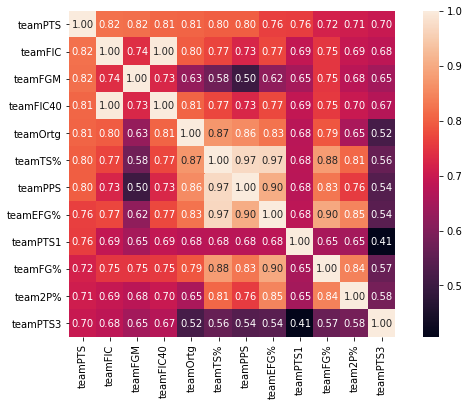

In [0]:
# cool stuff with the correlation matrix
# to understand what affects team result
k = 12
cols = corrmat.nlargest(k,'teamPTS')['teamPTS'].index
f, ax= plt.subplots(figsize=(10,6))
cm = np.corrcoef(df[cols].values.T) # calculates the coeffs
sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size':10},yticklabels=cols.values,xticklabels=cols.values)
plt.show()

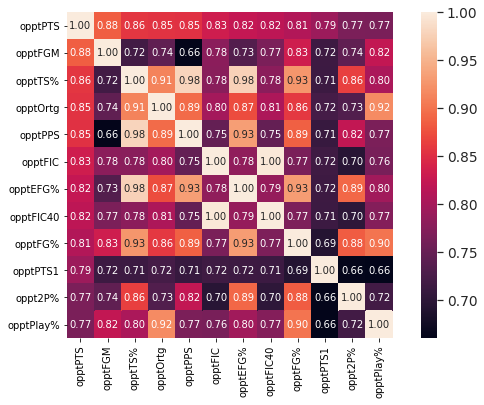

In [0]:
# or for opponent points
k = 12
cols = corrmat.nlargest(k, 'opptPTS')['opptPTS'].index
f, ax = plt.subplots(figsize=(10,6))
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [0]:
# Lets do some PCA on this new data: last answer here is good read https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
pca_df = df.copy()

pca_df.pop('gmDate')
pca_df.pop('teamAbbr')
pca_df.pop('teamLoc')
pca_df.pop('teamRslt')
pca_df.pop('opptAbbr')
pca_df.pop('opptLoc')
pca_df.pop('opptRslt')

pca = PCA(n_components=5)
pca.fit_transform(pca_df)
post_pca_data = pca.transform(pca_df)

print("Orig: ", df.shape)
print("PCA: ", post_pca_data.shape)

print(pd.DataFrame(post_pca_data))

pca_components = pd.DataFrame(pca.components_, columns=pca_df.columns, index = ['PC-1','PC-2','PC-3','PC-4','PC-5'])
print(pca_components)

good_features = []
for column in pca_components:
  vals = pca_components[column].values
  if max(abs(vals)) >= 0.8:
    good_features.append(column)

print(len(good_features))
good_features


Orig:  (1215, 108)
PCA:  (1215, 5)
              0          1          2          3         4
0      9.486230 -40.488504   9.072929 -13.867374  0.340041
1     21.865960 -36.095413  10.654986  -4.795815 -7.385462
2     -7.464002 -21.156463   4.262036 -16.140867  4.849805
3    -11.294598 -18.235056  -2.492158  -9.685828 -9.358593
4     26.830235 -17.315712  -5.783973 -13.893220  0.913731
...         ...        ...        ...        ...       ...
1210   1.654511  -8.559843   3.600131   4.459737 -6.881743
1211   1.124671  -8.199484   1.420855  -4.006233  1.643684
1212  11.704027  -8.093298  -0.495785 -18.227265  1.086107
1213  -8.155316  -8.923671   3.553566   3.103381  5.839705
1214   3.676547  -8.712200   2.231111  -0.962086  1.177392

[1215 rows x 5 columns]
      teamDayOff   teamPTS   teamAST  ...  opptAST/TO  opptSTL/TO      pace
PC-1   -0.000050 -0.005787  0.000772  ...   -0.011577   -0.294757 -0.028465
PC-2   -0.003919 -0.300693 -0.138018  ...   -0.000420   -0.009935 -0.041910
PC-3

['teamSTL/TO', 'opptSTL/TO']

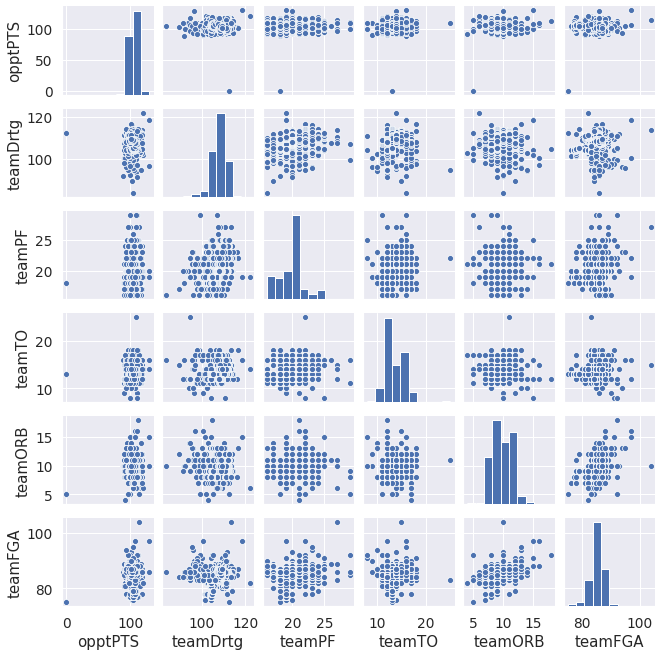

In [0]:
# cool sns feature
cols1 = ['opptPTS', 'teamDrtg', 'teamPF', 'teamTO', 'teamORB', 'teamFGA']
sns.pairplot(df[cols1], size=1.5)
plt.show()

In [0]:
# data preparation - split for training and testing
feature_cols = ['teamEDiff','opptEDiff','teamFIC40','opptFIC40','teamEFG%','opptEFG%','teamPlay%','opptPlay%' ,'pace']

x = df[feature_cols]
y = df['teamRslt']
y.replace(to_replace='Loss', value=0, inplace=True)
y.replace(to_replace='Win', value=1, inplace=True)

x_train = x[:1107]
x_test = x[1107:]
y_train = y[:1107]
y_test = y[1107:]

# and the training

# knn 
clf_knn = KNeighborsClassifier(n_neighbors=100)
clf_knn.fit(x_train,y_train)
knn_pred = clf_knn.predict(x_test)

# linear SVM -> did not know there were non linear SVMs lol
clf_svm = LinearSVC(C=10)
clf_svm.fit(x_train,y_train)
svm_pred = clf_svm.predict(x_test)

# SVC
clf_svmc = SVC(kernel='poly', C=10, degree=4)
clf_svmc.fit(x_train,y_train)
svmc_pred = clf_svmc.predict(x_test)

# random forest
clf_forest = RandomForestClassifier(n_estimators=100, max_depth=8)
clf_forest.fit(x_train,y_train)
forest_pred = clf_forest.predict(x_test)

# Gradient Tree Boosting
clf_gtb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=8)
clf_gtb.fit(x_train,y_train)
gtb_pred = clf_gtb.predict(x_test)

#Naive Bayes GaussianNB
clf_gnb = GaussianNB()
clf_gnb.fit(x_train, y_train)
gnb_pred = clf_gnb.predict(x_test)

# Accuracy Results
print('KNN: ',metrics.accuracy_score(y_test,knn_pred))
print('LinearSVM: ',metrics.accuracy_score(y_test,svm_pred))
print('Forest: ',metrics.accuracy_score(y_test,forest_pred))
print('Gradient Tree: ',metrics.accuracy_score(y_test,gtb_pred))
print('SVC: ',metrics.accuracy_score(y_test,svmc_pred))
print('Naive Bayes GaussianNB: ',metrics.accuracy_score(y_test,gnb_pred))


KNN:  0.6666666666666666
LinearSVM:  0.28703703703703703
Forest:  0.7129629629629629
Gradient Tree:  0.6944444444444444
SVC:  0.7222222222222222
Naive Bayes GaussianNB:  0.7407407407407407


In [0]:
# MLP Classifier
mlp = MLPClassifier(max_iter=50)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf_mlp = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf_mlp.fit(x_train, y_train)


# Best paramete set
print('Best parameters found:\n', clf_mlp.best_params_)

mlp_pred = clf_mlp.predict(x_test)

print('MLP: ',metrics.accuracy_score(y_test,mlp_pred))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
MLP:  0.6944444444444444


In [0]:
# Validation 

df2 = new_data2.copy()
# pick same data as before:
new_feature_cols = ['teamEDiff','opptEDiff','teamFIC40','opptFIC40','teamEFG%','opptEFG%','teamPlay%','opptPlay%','pace']

x2 = df2[new_feature_cols]
y2 = df2['teamRslt']
y2.replace(to_replace='Loss', value=0, inplace=True)
y2.replace(to_replace='Win', value=1, inplace=True)

x_new = x2[150:300]
y_new = y2[150:300]

# knn 
knn_res = clf_knn.predict(x_new)

# linear SVM -> did not know there were non linear SVMs lol
svm_res = clf_svm.predict(x_new)

# SVC
svmc_res = clf_svmc.predict(x_new)

# MPL Classifier
mlp_res = clf_mlp.predict(x_new)

# random forest
forest_res = clf_forest.predict(x_new)

# Gradient Tree Boosting
gtb_res = clf_gtb.predict(x_new)

#Naive Bayes GaussianNB
gnb_res = clf_gnb.predict(x_new)


print('Results on the 2017-18 season: ')
print('KNN: ',metrics.accuracy_score(y_new,knn_res))
print('LinearSVM: ',metrics.accuracy_score(y_new,svm_res))
print('Forest: ',metrics.accuracy_score(y_new,forest_res))
print('Gradient Tree: ',metrics.accuracy_score(y_new,gtb_res))
print('SVC: ',metrics.accuracy_score(y_new,svmc_res))
print('Naive Bayes GaussianNB: ',metrics.accuracy_score(y_new,gnb_res))
print('MPL: ',metrics.accuracy_score(y_new,mlp_res))


Results on the 2017-18 season: 
KNN:  0.6266666666666667
LinearSVM:  0.4666666666666667
Forest:  0.6
Gradient Tree:  0.5866666666666667
SVC:  0.5933333333333334
Naive Bayes GaussianNB:  0.62
MPL:  0.6066666666666667
